<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Laboratorio: Construcción Modelo de Clasificación y Evaluación de Métricas

Tras realizar el preprocesamiento de los datos y dejarlos listos para construir modelos, ha llegado el momento de dar el siguiente paso: desarrollar tu **primer modelo de clasificación**.

El objetivo de este laboratorio es implementar un modelo de clasificación inicial utilizando **Regresión Logística (Logistic Regression)**. Este modelo te permitirá obtener las primeras predicciones para identificar transacciones normales y anómalas, así como evaluar su desempeño utilizando métricas estándar.

Además, deberás evaluar si el modelo está en riesgo de **overfitting**, asegurando que nuestras predicciones sean consistentes tanto en los datos de entrenamiento como en los de prueba.






In [39]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import sys
sys.path.append("../")
# Importamos nuestras funciones
# -----------------------------------------------------------------------
from src import  soporte_ajuste_logistica as sal


# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Para realizar la clasificación y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import pickle
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler
from itertools import product , combinations
from sklearn.experimental import enable_iterative_imputer  # Necesario para habilitar IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

In [40]:
df = pd.read_csv("../datos/03_financial_data_minmaxscaler.csv")
df = pd.read_pickle("../datos/datos_preprocesados.pkl")

In [41]:
df.head()

,customer_id,merchant_id,amount,is_fraudulent,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,location_City-1,location_City-10,location_City-11,location_City-12,location_City-13,location_City-14,location_City-15,location_City-16,location_City-17,location_City-18,location_City-19,location_City-2,location_City-20,location_City-21,location_City-22,location_City-23,location_City-24,location_City-25,location_City-26,location_City-27,location_City-28,location_City-29,location_City-3,location_City-30,location_City-31,location_City-32,location_City-33,location_City-34,location_City-35,location_City-36,location_City-37,location_City-38,location_City-39,location_City-4,location_City-40,location_City-41,location_City-42,location_City-43,location_City-44,location_City-45,location_City-46,location_City-47,location_City-48,location_City-49,location_City-5,location_City-50,location_City-6,location_City-7,location_City-8,location_City-9,outliers_ifo_0.01_100,outliers_ifo_0.01_400,outliers_ifo_0.01_1000,outliers_ifo_0.01_2000,outliers_ifo_0.05_100,outliers_ifo_0.05_400,outliers_ifo_0.05_1000,outliers_ifo_0.05_2000,outliers_ifo_0.1_100,outliers_ifo_0.1_400,outliers_ifo_0.1_1000,outliers_ifo_0.1_2000
0,0.818182,0.262626,0.575423,0,0.900628,0.480769,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1,1,1,1,1
1,0.141414,0.525253,0.189301,1,0.143774,0.826923,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1,1,1,1,1
2,0.030303,0.343434,0.123960,1,0.900628,0.750000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1,1,1,-1,1
3,0.949495,0.363636,0.761671,1,0.512530,0.788462,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1,1,1,1,1
4,0.353535,0.828283,0.188153,1,0.678115,0.346154,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,1,1,1,1,1,1


# INFO VR
- 0: Normal (No)
- 1: Fraudulenta (Si)

## Objetivo del Laboratorio

1. Entrenar un modelo de **Regresión Logística** para predecir si una transacción es "Normal" o "Anómala".

In [42]:
params_logistic = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.005, 0.01,0.05, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [10,20,40,100,150]
}

In [43]:
# instanciamos la clase de regresión logistica
logistica = sal.AnalisisModelosClasificacion(dataframe = df, variable_dependiente = "is_fraudulent",train_size=0.7)

# llamamos a la función para ajustar el modelo
logistica.ajustar_modelo("logistic_regression",param_grid = params_logistic,ruta_guardar_modelo="../datos/modelos-encoders/",nombre_modelo_guardar="logistic_model.pkl")

# Evaluar el desempeño del modelo utilizando métricas como:






### Matriz de confusión.

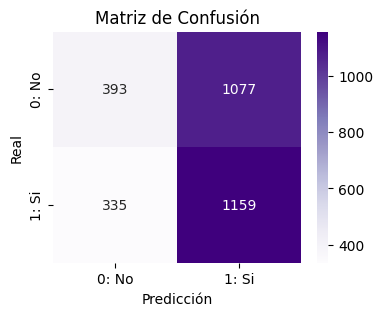

In [44]:
logistica.plot_matriz_confusion("logistic_regression",invertir=False,labels=True,label0="No",label1="Si")

   ### Precisión (Accuracy), Precisión (Precision), exhaustividad (Recall) y F1-Score.

In [45]:
# llamamos al metodo para obtener los resultaods de las predicciones
df_resultados = logistica.calcular_metricas(modelo_nombre =  "logistic_regression")
df_resultados.T

,accuracy,precision,recall,f1,kappa,auc
train,0.529216,0.532552,0.529216,0.497733,0.049499,0.552713
test,0.523617,0.528999,0.523617,0.490591,0.043292,0.525825


# Interpretar resultados
### Accuracy
- Un `accuracy` alto significa que el modelo predice correctamente la mayoría de las veces, aunque es importante evaluar si las clases están balanceadas para asegurar que no sea engañoso.
- En nuestro caso ambos valores son bajos, lo que puede sugerir que el modelo no está aprendiendo patrones significativos, especialmente en datos de prueba, donde apenas supera el azar (que sería cercano al 50% si las clases están balanceadas).
### Precision
- Un valor de `precision` alto indica que el modelo tiene pocos falsos positivos.
- En nuestro caso una precisión tan baja sugiere que el modelo genera bastantes falsos positivos, lo que podría ser crítico dependiendo del problema (por ejemplo, en fraudes, se podrían marcar como fraudulentos muchos casos legítimos)
### Recall
- Un `recall` alto significa que el modelo detecta correctamente la mayoría de los casos positivos, lo que es clave cuando es más costoso pasar por alto casos positivos (como en diagnósticos médicos).
- El modelo tiene un rendimiento bajo en términos de recall, lo que indica que se pierden muchos casos positivos.
### F1
- Un valor alto de `F1 Score` indica un equilibrio adecuado entre `precision` y `recall`.
- Los valores bajos del F1 Score refuerzan la idea de que el modelo no es eficaz en general, tanto en precisión como en recall.
### Kappa
- Mide el grado de acuerdo entre las predicciones del modelo y las etiquetas reales, corrigiendo el acuerdo esperado por azar
- Estos valores reflejan un modelo pobremente calibrado, incapaz de encontrar patrones relevantes en los datos.
### AUC
- Evalúa la capacidad del modelo para separar correctamente las clases. Un AUC de 0.5 indica que el modelo no tiene capacidad discriminativa (equivalente a adivinar al azar).
- Este valor confirma que el modelo no está aprendiendo patrones útiles para separar las clases de manera significativa.

### Área bajo la curva ROC (AUC-ROC).

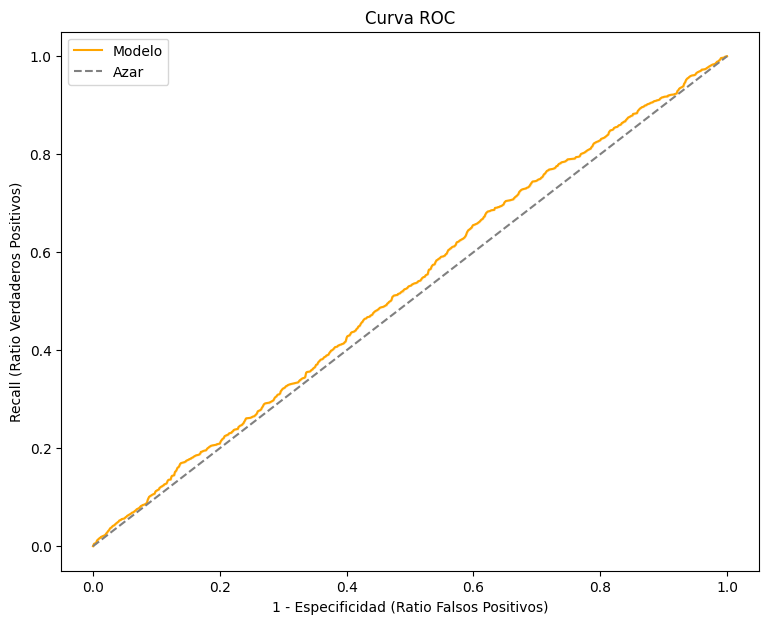

In [46]:
logistica.plot_curva_ROC()

# Parte 3
3. Determinar si el modelo presenta **overfitting** o **underfitting**, analizando el rendimiento en los datos de entrenamiento y prueba.

In [47]:
df_resultados["diferencia"] = df_resultados["train"] - df_resultados["test"]
df_resultados

,train,test,diferencia
accuracy,0.529216,0.523617,0.005599
precision,0.532552,0.528999,0.003554
recall,0.529216,0.523617,0.005599
f1,0.497733,0.490591,0.007142
kappa,0.049499,0.043292,0.006207
auc,0.552713,0.525825,0.026888


Overfitting en este caso no hay, pero las métricas no son buenas

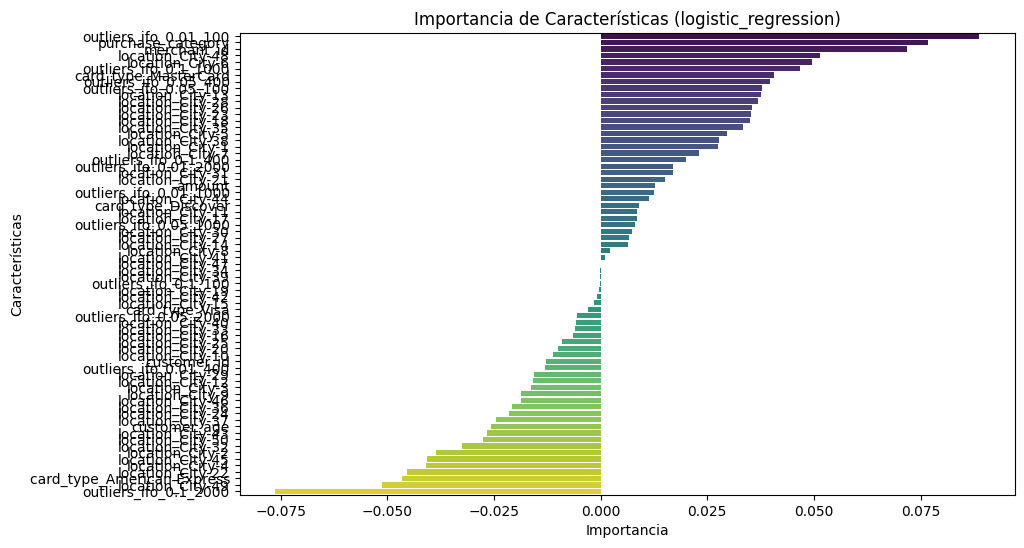

In [48]:
# Mostramos la importancia de los predictores en el modelo regresión logística
logistica.importancia_predictores(modelo_nombre ='logistic_regression')

# Shap Plots
- Nos enseña si afecta positivamente o negativamente a la VR
- pip install shap
- Muestra como cada dato afecta a la predicción
- También calcula realcion Variables
- Es más real que la importancia
- El orden lo determina mediante la teoría de juegos